In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


def preprocess_loan_data(file_path: str):
    """
    Read and preprocess the loan dataset:
    - Handle missing values
    - Convert binary categorical variables to numeric
    - Print summary statistics

    Returns
    -------
    df : pd.DataFrame
        The cleaned DataFrame.
    numeric_cols : list
        List of numeric column names.
    categorical_cols : list
        List of remaining (non-binary) categorical column names.
    """
    # Step 1: Load dataset
    df = pd.read_csv(file_path)

    # Step 2: Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Step 3: Report missing values before imputation
    print("=== Missing Values Before Imputation ===")
    missing_before = df.isnull().sum().loc[lambda x: x > 0]
    print(missing_before if not missing_before.empty else "No missing values")
    print()

    # Step 4: Impute numeric columns using median
    for col in numeric_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

    # Step 5: Impute categorical columns using mode
    for col in categorical_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mode(dropna=True)[0])

    # Step 6: Convert binary categorical columns to numeric (0/1)
    binary_cols = [
        col for col in categorical_cols
        if df[col].nunique(dropna=False) == 2
    ]
    for col in binary_cols:
        uniques = list(df[col].unique())
        mapping = {uniques[0]: 0, uniques[1]: 1}
        df[col] = df[col].map(mapping)
        print(f"Converted binary column '{col}' to numeric with mapping {mapping}")

    # Step 7: Update column lists after conversion
    categorical_cols = [col for col in categorical_cols if col not in binary_cols]
    numeric_cols += binary_cols

    # Step 8: Report missing values again
    print("\n=== Missing Values After Imputation ===")
    missing_after = df.isnull().sum().loc[lambda x: x > 0]
    print(missing_after if not missing_after.empty else "All missing values have been filled")
    print()

    # Step 9: Summary statistics for numeric columns
    print("=== Numeric Summary ===")
    print(df[numeric_cols].describe().T)
    print()

    # Step 10: Frequency & percentage for categorical columns
    for col in categorical_cols:
        counts = df[col].value_counts(dropna=False)
        percentages = counts / len(df) * 100
        summary_df = pd.DataFrame({
            'count': counts,
            'percentage': percentages.round(2)
        })
        print(f"=== Summary for '{col}' ===")
        print(summary_df)
        print()

    return df, numeric_cols, categorical_cols


In [2]:
def visualize_categorical_distributions(
    df: pd.DataFrame,
    columns: list = None,         
    max_categories: int = 10,
    font_family: str = 'Times New Roman',
    save_plots: bool = False,
    save_dir: str = './'
):
    mpl.rcParams['font.family'] = font_family

    # If columns is not provided, fall back to all columns in df
    if columns is None:
        columns = df.columns.tolist()

    # Only include columns with number of unique values ≤ max_categories
    filtered_cols = [
        col for col in columns
        if df[col].nunique(dropna=False) <= max_categories
    ]

    for col in filtered_cols:
        counts = df[col].value_counts(dropna=False)
        labels = [str(v) if pd.notnull(v) else 'Missing' for v in counts.index]
        sizes  = counts.values

        fig, ax = plt.subplots(figsize=(6, 6))
        wedges, texts, autotexts = ax.pie(
            sizes,
            autopct='%1.1f%%',
            startangle=140,
            textprops={'fontsize': 13, 'fontfamily': font_family}
        )

        ax.legend(
            wedges, labels,
            title=col,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.4, 1),
            fontsize=12,
            title_fontsize=13
        )
        ax.set_title(f'Distribution of {col}', fontsize=24, fontfamily=font_family)
        fig.subplots_adjust(top=0.88, right=0.78)
        ax.axis('equal')

        plt.show()


=== Missing Values Before Imputation ===
Gender              13
Married              3
Dependents          15
Self_Employed       32
LoanAmount          22
Loan_Amount_Term    14
Credit_History      50
dtype: int64

Converted binary column 'Gender' to numeric with mapping {'Male': 0, 'Female': 1}
Converted binary column 'Married' to numeric with mapping {'No': 0, 'Yes': 1}
Converted binary column 'Education' to numeric with mapping {'Graduate': 0, 'Not Graduate': 1}
Converted binary column 'Self_Employed' to numeric with mapping {'No': 0, 'Yes': 1}
Converted binary column 'Loan_Status' to numeric with mapping {'Y': 0, 'N': 1}

=== Missing Values After Imputation ===
All missing values have been filled

=== Numeric Summary ===
                   count         mean          std    min      25%     50%  \
ApplicantIncome    614.0  5403.459283  6109.041673  150.0  2877.50  3812.5   
CoapplicantIncome  614.0  1621.245798  2926.248369    0.0     0.00  1188.5   
LoanAmount         614.0   145

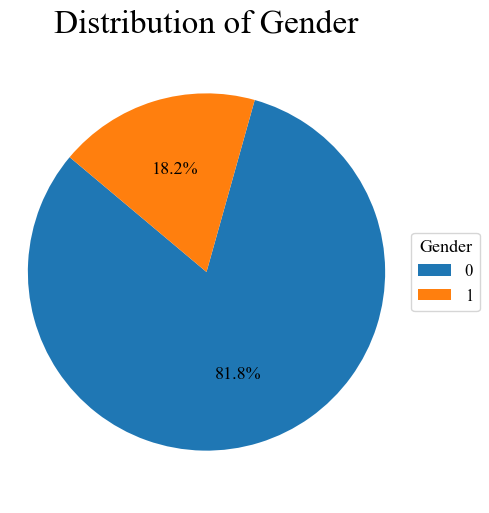

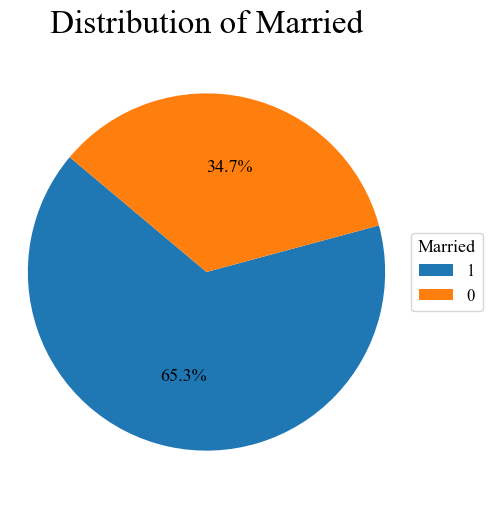

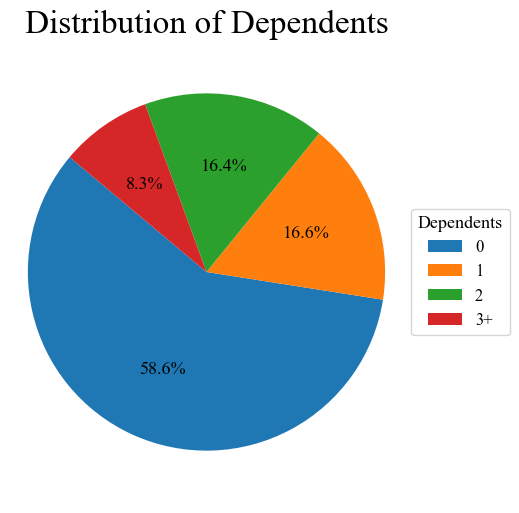

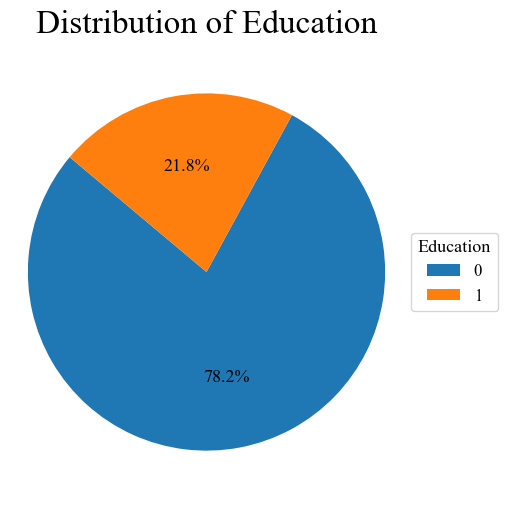

In [ ]:
# Step 1: Clean the data
df_clean, numeric_cols, categorical_cols = preprocess_loan_data('../data/loan-train.csv')

# Step 2: Visualize the categorical columns
visualize_categorical_distributions(df_clean, columns=['Gender', 'Married', 'Dependents', 'Education'])


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def train_logistic_model(df, target_col, categorical_cols, test_size=0.2, random_state=42):
    """
    Train a Logistic Regression model on the loan dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed loan dataset.
    target_col : str
        Name of the target column.
    categorical_cols : list
        List of categorical columns to be one-hot encoded.
    test_size : float
        Proportion of test set, default 0.2.
    random_state : int
        Random seed for reproducibility.

    Returns
    -------
    model : trained LogisticRegression model
    X_test : pd.DataFrame
        Features from test set.
    y_test : pd.Series
        True labels from test set.
    y_pred : np.ndarray
        Predicted labels on test set.
    """
    # Step 1: Encode target if categorical
    if df[target_col].dtype not in [int, float]:
        mapping = {label: idx for idx, label in enumerate(df[target_col].unique())}
        df[target_col] = df[target_col].map(mapping)
        print(f"Target '{target_col}' encoded as: {mapping}")

    # Step 2: Split features and labels
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Step 3: One-hot encode categorical variables
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Step 4: Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Step 5: Initialize and train Logistic Regression model
    model = LogisticRegression(
        max_iter=1000,
        random_state=random_state,
        C=0.01,
        penalty='l2',
        solver='lbfgs'
    )
    model.fit(X_train, y_train)

    # Step 6: Predict and evaluate
    y_pred = model.predict(X_test)

    print("\n=== Logistic Regression Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")

    return model, X_test, y_test, y_pred

logistic_model, X_test, y_test, y_pred = train_logistic_model(df_clean, 'Loan_Status', categorical_cols)


=== Logistic Regression Evaluation ===
Confusion Matrix:
[[85  0]
 [37  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        85
           1       1.00      0.03      0.05        38

    accuracy                           0.70       123
   macro avg       0.85      0.51      0.44       123
weighted avg       0.79      0.70      0.58       123

Accuracy Score: 0.6992


In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

def train_decision_tree_model(df, target_col, categorical_cols, test_size=0.2, random_state=42):
    """
    Train a Decision Tree classifier and evaluate its performance.
    This function follows the same structure and processing steps 
    as the logistic regression model for consistency.

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned dataset after preprocessing.
    target_col : str
        The target column name (e.g., 'Loan_Status').
    categorical_cols : list
        List of categorical variables that require one-hot encoding.
    test_size : float
        Proportion of the dataset used for testing.
    random_state : int
        Seed for reproducibility.

    Returns
    -------
    model : DecisionTreeClassifier
        Trained decision tree model.
    X_test : pd.DataFrame
        Test set features after encoding.
    y_test : pd.Series
        True labels for the test set.
    y_pred : np.array
        Predicted labels for the test set.
    """
    print("\n================ Decision Tree Model ================\n")

    # Split features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Apply one-hot encoding to categorical variables
    # Keep drop_first=True for consistency with logistic regression
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Train-test split with stratification to preserve class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Initialize and train the Decision Tree classifier
    dt_model = DecisionTreeClassifier(
        random_state=random_state
        # Using default hyperparameters for minimal modification;
        # tuning can be added later if needed.
    )
    dt_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = dt_model.predict(X_test)

    # Evaluation results
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    return dt_model, X_test, y_test, y_pred

dt_model, X_test_dt, y_test_dt, y_pred_dt = train_decision_tree_model(
    df_clean, 'Loan_Status', categorical_cols
)



================ Decision Tree Model ================

Confusion Matrix:
[[71 14]
 [18 20]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        85
           1       0.59      0.53      0.56        38

    accuracy                           0.74       123
   macro avg       0.69      0.68      0.69       123
weighted avg       0.73      0.74      0.74       123

Accuracy: 0.7398373983739838


In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

def tune_random_forest_model(df, target_col, categorical_cols, test_size=0.2, random_state=42):
    """
    Perform hyperparameter tuning and evaluation for a Random Forest classifier
    on a loan eligibility dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Cleaned and preprocessed dataset containing both features and target.
    target_col : str
        Name of the column to be used as the target (dependent variable).
    categorical_cols : list of str
        Names of categorical feature columns to be one-hot encoded.
    test_size : float, optional
        Proportion of data to use for the test set (default is 0.2).
    random_state : int, optional
        Random seed for reproducibility (default is 42).

    Returns
    -------
    best_model : RandomForestClassifier
        The best-trained Random Forest model with optimal hyperparameters.
    X_test : pd.DataFrame
        Feature set of the test partition.
    y_test : pd.Series
        True labels corresponding to X_test.
    y_pred : np.ndarray
        Model predictions on the test set.
    """

    # Encode the target column to numeric if it's categorical (e.g., Yes/No)
    if df[target_col].dtype not in [int, float]:
        mapping = {label: idx for idx, label in enumerate(df[target_col].unique())}
        df[target_col] = df[target_col].map(mapping)
        print(f"Target '{target_col}' encoded as: {mapping}")

    # Split features and labels
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # One-hot encode categorical columns (keeping all dummy variables)
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Define an expanded grid of hyperparameters for stronger Random Forest performance
    param_grid = {
        'n_estimators': [300, 600, 1000],      # Increase tree count
        'max_depth': [None, 15, 25],           # Allow deeper trees
        'min_samples_split': [2, 3, 5],        # Slightly relaxed
        'min_samples_leaf': [1, 2, 4],         # Allow pure leaves
        'max_features': ['sqrt', 'log2', None], # Try all features
        'class_weight': ['balanced', 'balanced_subsample']  # help imbalanced data
    }

    # Perform grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=random_state),
        param_grid=param_grid,
        cv=10,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Fit the model on training data
    grid_search.fit(X_train, y_train)

    # Retrieve the best model and evaluate it on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Output evaluation results
    print("\n=== Best Hyperparameters ===")
    print(grid_search.best_params_)
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

    print("\n=== Test Set Evaluation ===")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    return best_model, X_test, y_test, y_pred

best_rf_model, X_test2, y_test2, y_pred2 = tune_random_forest_model(df_clean, 'Loan_Status', categorical_cols)


Fitting 10 folds for each of 486 candidates, totalling 4860 fits

=== Best Hyperparameters ===
{'class_weight': 'balanced', 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
Best Cross-Validation Accuracy: 0.8107

=== Test Set Evaluation ===
Confusion Matrix:
[[82  3]
 [20 18]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.96      0.88        85
           1       0.86      0.47      0.61        38

    accuracy                           0.81       123
   macro avg       0.83      0.72      0.74       123
weighted avg       0.82      0.81      0.79       123

Test Accuracy: 0.8130


In [ ]:
# Step 1: Load and preprocess the test data
test_df, _, test_categorical_cols = preprocess_loan_data("../data/loan-test.csv")

# Step 2: One-hot encode categorical variables
X_input = pd.get_dummies(test_df, columns=test_categorical_cols, drop_first=True)

# Step 3: Align columns with training data (X_test.columns must come from training phase)
X_input = X_input.reindex(columns=X_test.columns, fill_value=0)

# Step 4: Predict class labels (0 or 1)
y_pred_new = logistic_model.predict(X_input)

# Step 5: Predict probabilities
y_pred_prob = logistic_model.predict_proba(X_input)[:, 1]

# Step 6: Map numerical predictions back to 'N' and 'Y'
label_map = {0: 'N', 1: 'Y'}
y_pred_label = pd.Series(y_pred_new).map(label_map)

# Step 7: Print results
print("Predicted Loan Status (Y=Approved, N=Rejected):")
print(y_pred_label.values)
print("\nApproval Probabilities:")
print(y_pred_prob)

# Step 8: Add predictions to the original test DataFrame
test_df["Predicted_Status"] = y_pred_label
test_df["Approval_Probability"] = y_pred_prob

# Step 9: Save results to CSV
test_df.to_csv("../data/loan-test-predictions.csv", index=False)
print("\nSaved predictions to '../data/loan-test-predictions.csv'")



=== Missing Values Before Imputation ===
Gender              11
Dependents          10
Self_Employed       23
LoanAmount           5
Loan_Amount_Term     6
Credit_History      29
dtype: int64

Converted binary column 'Gender' to numeric with mapping {'Male': 0, 'Female': 1}
Converted binary column 'Married' to numeric with mapping {'Yes': 0, 'No': 1}
Converted binary column 'Education' to numeric with mapping {'Graduate': 0, 'Not Graduate': 1}
Converted binary column 'Self_Employed' to numeric with mapping {'No': 0, 'Yes': 1}

=== Missing Values After Imputation ===
All missing values have been filled

=== Numeric Summary ===
                   count         mean          std   min     25%     50%  \
ApplicantIncome    367.0  4805.599455  4910.685399   0.0  2864.0  3786.0   
CoapplicantIncome  367.0  1569.577657  2334.232099   0.0     0.0  1025.0   
LoanAmount         367.0   135.980926    60.959739  28.0   101.0   125.0   
Loan_Amount_Term   367.0   342.822888    64.658402   6.0   360